In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import ot  
import ot.plot
%matplotlib inline

2024-05-19 21:24:30.820469: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 21:24:31.925658: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 21:24:34.171230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:24:37.531974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Discrete Optimal Transport problem (2 marginals)

To begin with, I will explain the structure of the file.
We will define the *key objects* that we are dealing with in OT, and provide examples of them after I define each *key object*. Throughout the file there will be 2 main (simple-case) examples: for $\mathbb{R}^1$ and for $\mathbb{R}^2$. When we refer to each example, we will fix some objects and they will reappear later in the corresponding example-problems. 

In this file, I will use a Python library `POT` to provide already implemented code examples for solving/approximating Optimal Transort plans as well as the approach using our `dnn` module that uses Neural Networks motivated by the paper [_Meta Optimal Transport - Amos et all, 2022_].


##### For the Example 1 (1-dimensional) we will talk about a particular probability distribution: discretization of Gaussian (or Normal) distribution. 

##### For the Example 2 (2-dimensional) we will consider simply some small sets in $\mathbb{R}^2$ with "some" probabilities assigned to them.

To distinguish between these examples, we will use the indeces, e.g. for Example 1, I will use `mu_1`, `nu_1` and so on. 

## Space of coordinates
$X = \{x_0,\dots, x_{n-1}\}, ~ Y = \{y_0,\dots, y_{m-1}\}$ -- Sets of points in $\mathbb{R}^d$.

#### Example 1 

In [2]:
X_1 = np.linspace(0,4, 101)
Y_1 = np.linspace(0,4, 101) 
# it is not necessary to have different spaces, the important part are the distributions. 

print(X_1)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.   1.04 1.08
 1.12 1.16 1.2  1.24 1.28 1.32 1.36 1.4  1.44 1.48 1.52 1.56 1.6  1.64
 1.68 1.72 1.76 1.8  1.84 1.88 1.92 1.96 2.   2.04 2.08 2.12 2.16 2.2
 2.24 2.28 2.32 2.36 2.4  2.44 2.48 2.52 2.56 2.6  2.64 2.68 2.72 2.76
 2.8  2.84 2.88 2.92 2.96 3.   3.04 3.08 3.12 3.16 3.2  3.24 3.28 3.32
 3.36 3.4  3.44 3.48 3.52 3.56 3.6  3.64 3.68 3.72 3.76 3.8  3.84 3.88
 3.92 3.96 4.  ]


#### Example 2

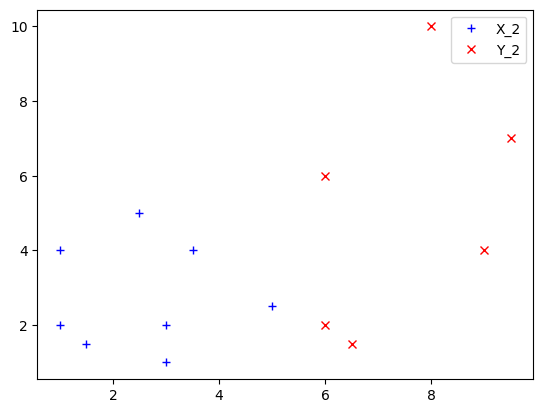

In [3]:
X_2 = np.array([[1, 2],
                [3, 1],
                [1.5, 1.5],
                [3, 2],
                [2.5, 5],
                [3.5, 4],
                [1, 4],
                [5, 2.5]])

Y_2 = np.array([[8, 10],
                [6.5, 1.5],
                [6, 2],
                [9.5, 7],
                [9, 4],
                [6, 6],])

plt.figure(1)
plt.plot(X_2[:, 0], X_2[:, 1], '+b', label='X_2')
plt.plot(Y_2[:, 0], Y_2[:, 1], 'xr', label='Y_2')
plt.legend(loc=0)
plt.show()

## Probability distributions
$\mu = (\mu_0, \dots, \mu_{n-1}), ~\nu =  (\nu_0, \dots, \nu_{m-1})$ -- Probability distributions on $X$ and $Y$, respectively.

In this notation, we can say that the "probability" of the object to be at the point $x_i$ is equal to $\mu_i$.

#### Example 1


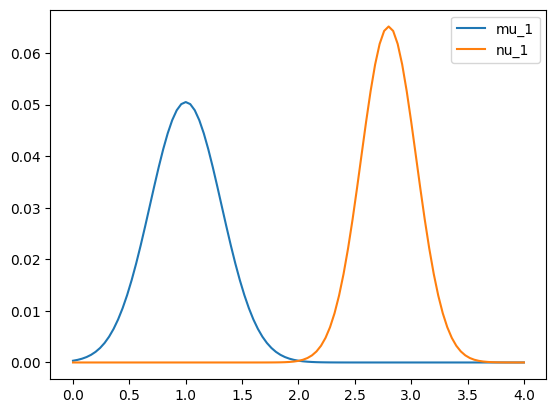

In [4]:
def discrete_gaussian(mean, variance, interval): 
    f = np.exp(-(interval-mean)**2/(2*variance)) / np.sqrt(2*np.pi*variance)
    return f/f.sum()

mu_1 = discrete_gaussian(1, 0.1, X_1)
nu_1 = discrete_gaussian(2.8, 0.06, Y_1)

plt.figure(2)
plt.plot(X_1, mu_1, label="mu_1")
plt.plot(Y_1, nu_1, label="nu_1")
plt.legend(loc=0)

#### Example 2

In [5]:
np.random.seed(0)
# random values of mass at points of X_2 and Y_2, respectively
rand_21 = np.random.randint(10, size=len(X_2))
rand_22 = np.random.randint(10, size=len(Y_2)) 

# normalize the mass into "probabilities"
mu_2 = rand_21/rand_21.sum()
nu_2 = rand_22/rand_22.sum() 

print("Mass on the space X_2:")
for i in range(len(X_2)):
    print(f"{X_2[i]} : {mu_2[i]}" )

print("Mass on the space Y_2:")
for i in range(len(Y_2)):
    print(f"{Y_2[i]} : {nu_2[i]}" )

Mass on the space X_2:
[1. 2.] : 0.14285714285714285
[3. 1.] : 0.0
[1.5 1.5] : 0.08571428571428572
[3. 2.] : 0.08571428571428572
[2.5 5. ] : 0.2
[3.5 4. ] : 0.2571428571428571
[1. 4.] : 0.08571428571428572
[5.  2.5] : 0.14285714285714285
Mass on the space Y_2:
[ 8. 10.] : 0.05714285714285714
[6.5 1.5] : 0.11428571428571428
[6. 2.] : 0.2
[9.5 7. ] : 0.17142857142857143
[9. 4.] : 0.22857142857142856
[6. 6.] : 0.22857142857142856


## Couplings of $\mu$ and $\nu$ (or joint probability distributions)
$P = \begin{pmatrix} P_{00} & \dots & P_{0 (m-1)}\\
\vdots & \ddots & \vdots \\
P_{(n-1)0} & \dots & P_{(n-1)(m-1)}
\end{pmatrix}$ -- possible "coupling" between $\mu$ and $\nu$, i.e. such that $\sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}$ and $\sum\limits_{j=0}^{m-1} P_{ij} = \mu_i$. 

One of the ways to view $P_{ij}$ is: How much mass we will take from the point $x_i$ and send to $y_j$.

Another viewpoint: $P_{ij}$ says what is the "probability" of the object to be at the point $(x_i,y_j)$.

### Fact: if you take a matrix $P_{ij} = \mu_i \times \nu_{j}$, it always satisfies the "marginal" conditions
##### However, this particular $P$ is never the best solution for the Optimal Transport problem

Let's plot the examples of $P$ of this shape. It is very nice to look at those big matrices in terms of heatmaps. In the pictures below, each pixel of the "square" contains a value: "How much mass to take from x_i and move to y_j", so it is simply a color representation of the matrix $P$. Also, if you sum the matrix vertically, you will get the graph on the top -- distribution $\nu$. Similarly, if you sum horizontally, we get the graph on the left -- distrubution $\mu$.

###### Side comment: the numbers 0, 1, 2, ... and so on on this plots represent the indeces of the points in our spaces $X$ or $Y$. The upper left corner corresponds to $(x_0, y_0)$ up to the bottom right corner $(x_{n-1}, y_{m-1})$ 

#### Example 1


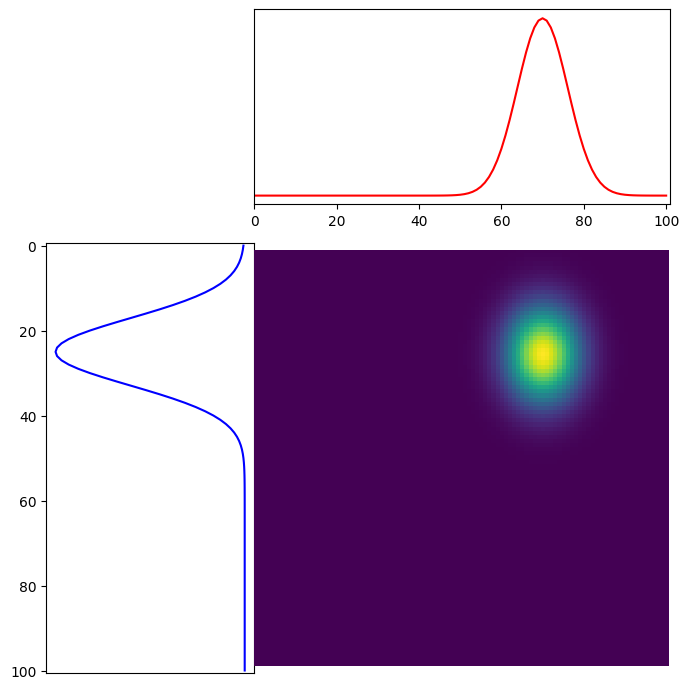

In [6]:
P_1_bad = mu_1[:, None] * nu_1[None, :]

plt.figure(5, figsize=(7,7))
ot.plot.plot1D_mat(mu_1, nu_1, P_1_bad)

#### Example 2

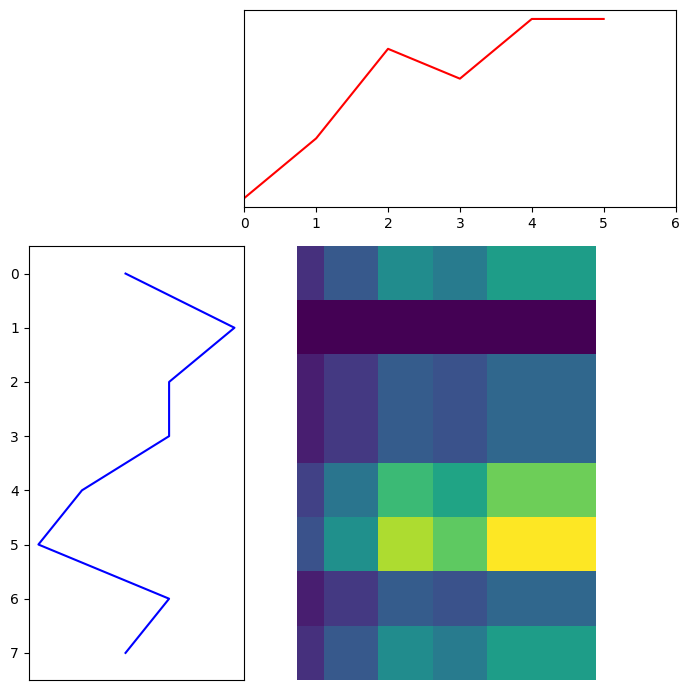

In [7]:
P_2_bad = mu_2[:, None] * nu_2[None, :]

plt.figure(6, figsize=(7,7))
ot.plot.plot1D_mat(mu_2, nu_2, P_2_bad)

## Cost matrix
$C = \begin{pmatrix} C_{00} & \dots & C_{0 (m-1)}\\
\vdots & \ddots & \vdots \\
C_{(n-1)0} & \dots & C_{(n-1)(m-1)}
\end{pmatrix}$ -- tells how much we would "pay" to transport a unit of mass from the point $x_i$ to $y_j$.

We can also view $C$ in the heatmaps, the logic of what each pixel stands for is as despribed above.



#### Example 1
Let's take the base function $c(x,y) = \frac{1}{1+|x-y|}$, e.g. $C[i,j] = \frac{1}{(1+ |X_2[i]-Y_2[j]|)}$

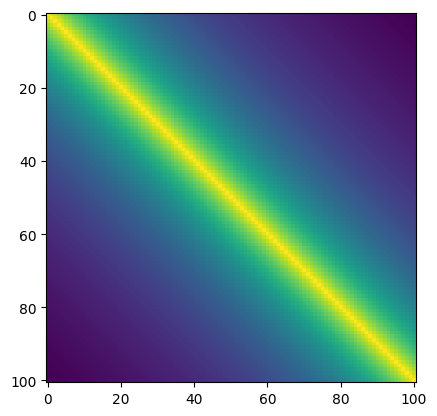

In [8]:
C_1 = 1 / (1 + np.abs(X_1[:, None] - Y_1[None, :]))

# How does it look like?
plt.figure(3)
plt.imshow(C_1)

# the biggest values are on the diagonal and decay away from the diagonal

#### Example 2
Let's take the base funcition $c(x,y) = ||x-y||^2 = (x^1-y^1)^2 + (x^2-y^2)^2$

[[113.    30.5   25.    97.25  68.    41.  ]
 [106.    12.5   10.    78.25  45.    34.  ]
 [114.5   25.    20.5   94.25  62.5   40.5 ]
 [ 89.    12.5    9.    67.25  40.    25.  ]
 [ 55.25  28.25  21.25  53.    43.25  13.25]
 [ 56.25  15.25  10.25  45.    30.25  10.25]
 [ 85.    36.5   29.    81.25  64.    29.  ]
 [ 65.25   3.25   1.25  40.5   18.25  13.25]]


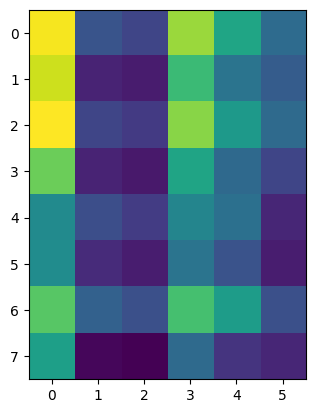

In [9]:
comp1 = (X_2[:, 0][:, None] - Y_2[:, 0][None, :]) ** 2 # difference squared of the first components
comp2 = (X_2[:, 1][:, None] - Y_2[:, 1][None, :]) ** 2 # difference squared of the second components

C_2 = comp1 + comp2

print(C_2) # C[i, j] tells you how much we "pay" to transfer mass from the point X[i]=(x1, x2) to Y[j]=(y1, y2)

plt.figure(4)
plt.imshow(C_2)

### Important notice: From now on it doesn't matter "what" are the coordinates where our "mass" is. Everyting necessary is already encoded in $\mu, ~\nu$ and $C$. 

### (Reminder) What do we want to compute (approximate) in Optimal Transport?

$P^*\in \argmax \{F_C(P) := \sum\limits_{i=0}^{n-1}\sum_{j=0}^{m-1}C_{ij}P_{ij} \,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\}$

### Important fact: typically, the best solution will look almost like a "line" or a "curve" when you look at the picture. It can help us to see "how good" we are estimating the solution, more or less it is a "sanity check".

In this tutorial we will focus on how we can actually estimate OT via Neural Networks 

### The regularized (Primal) problem 

Fix $\varepsilon>0$. Now instead we are looking for a solution of

$P^{\varepsilon}\in \argmax \{F^{\varepsilon}_C(P) := \sum\limits_{i=0}^{n-1}\sum_{j=0}^{m-1}C_{ij}P_{ij} +\varepsilon \sum\limits_{i=0}^{n-1}\sum_{j=0}^{m-1} P_{ij}(\log P_{ij}-1)\,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\}$



Pros: can define a nice algorithm that is faster to compute, provides approximation to the solution of the problem for $\varepsilon$ small enough.

Cons: the solution is never exact, may get to the point when there is a division by almost 0.


### The regularized Dual problem

Consider a different function $D^{\varepsilon}_{C}:\mathbb{R}^n \times \mathbb{R}^m \to \mathbb{R}:$

$D^{\varepsilon}_{C}(u,v) = \sum_{i=1}^n u_i \mu_i + \sum_{j=1}^m v_j \nu_j - \varepsilon \sum_{i=1}^n\sum_{j=1}^m e^{\frac{u_i+v_j - C_{ij}}{\varepsilon}}$

#### Facts (Optimization Theory): 
1. It turns out that

$$\min \{F^{\varepsilon}_C(P) \,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\} = \max \{ D^{\varepsilon}_C(u,v) \,:\, u\in \mathbb{R}^n,~ v\in \mathbb{R}^m\}.$$

2. There exists a unique minimizer $P^{\varepsilon}$ of $F^{\varepsilon}_C$ and it has a shape 
$$ 
P^{\varepsilon}_{ij}  = e^{\frac{u^{\varepsilon}_i+v^{\varepsilon}_j - C_{ij}}{\varepsilon}},
$$
where $u^{\varepsilon}_i$ and $v^{\varepsilon}_j$ are (any) maximizers of the Dual problem $D^{\varepsilon}_C$. 


## Neural Network approach
Notice that the Dual problem is a _strictly concave_ function, so we can exploit it as a Loss function for a Neural Network.


`Input`: marginals $\mu, \nu$ and Cost $C$.

`Output`: dual potentials $u$ and $v$.

`Algorithm`:

1. Parametrize potentials $u^\theta$ with deep neural network.
2. Compute $v^\theta$ such that it satisfies the marginal $\nu$ via half-Sinkhorn iteration.
3. Apply backpropagation using $-D^\varepsilon(u^\theta,v^\theta)$ as Loss function


We will now use our implemented model. 

In [11]:
from dnn import Shannon_network

ImportError: libGL.so.1: cannot open shared object file: No such file or directory